In [2]:
import numpy as np
import pandas as pd
import os
import random
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import Adam
import seaborn as sns
from ta.volatility import AverageTrueRange
from ta.momentum import RSIIndicator
import yfinance as yf

from lstm_functions import *
from loss_functions import *

Data loading

In [3]:
dataDirectory = os.path.join(os.getcwd(), 'scrapped_data')
fullStockList = [file[:-4] for file in os.listdir(dataDirectory) if file[-3:]=="csv"]

Feature correlation

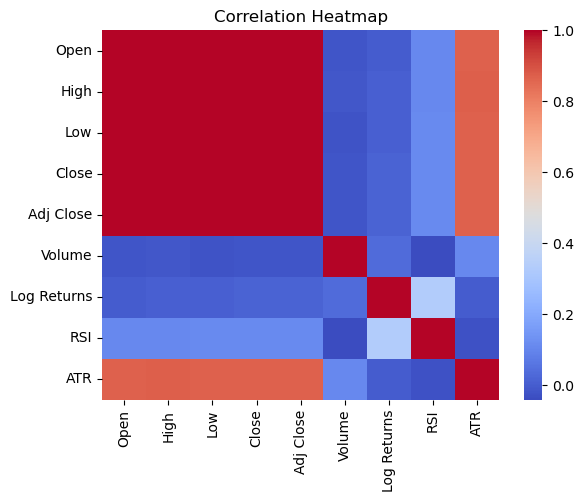

In [24]:
nvda = pd.read_csv(os.path.join(dataDirectory, 'NVDA.csv'))
nvda = nvda.set_index('Date')
sns.heatmap(nvda.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Feature importance

MSE = 103.66143032675589


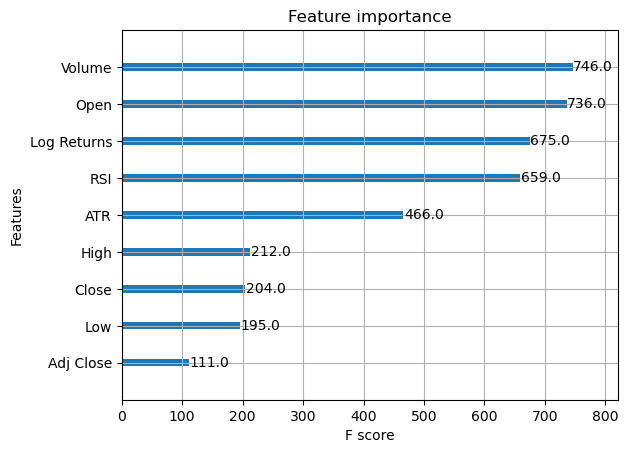

In [49]:
nvda["Adj Close_nextday"] = nvda["Adj Close"].shift(-1)
split = int(len(nvda) * 0.8)

train, test = nvda.iloc[:split], nvda.iloc[split:-1]
x_train, x_test = train.drop("Adj Close_nextday", axis=1), test.drop("Adj Close_nextday", axis=1)
y_train, y_test = train["Adj Close_nextday"], test["Adj Close_nextday"]

dtrain = xgb.DMatrix(x_train, label=y_train)
params = {
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse'
}
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)
y_pred = bst.predict(xgb.DMatrix(x_test))
print(f'MSE = {mean_squared_error(y_pred, y_test)}')

xgb.plot_importance(bst)
plt.show()

###### <b> \## Consider dropping Adj Close, Low, Close, High

Choose no. of stocks to use, and those with full 10 years of data

In [4]:
numStocks = 100

rawData = {}
stockList = []
startDate = '2009-01-02'
endDate = '2019-12-31'

for stock in fullStockList:
    stock_data = pd.read_csv(os.path.join(dataDirectory, f'{stock}.csv'))
    if stock_data['Date'][0] == startDate:
        stock_data = stock_data.set_index("Date")
        rawData[stock] = stock_data
        stockList.append(stock)
    if len(stockList) == numStocks:
        break
len(stockList)

100

Data engineering

In [9]:
# Initialize an empty DataFrame to store the data
data = pd.DataFrame()

# Loop through each stock symbol
for s in stockList:
    stock = rawData[s]
    
    ## Calculate ATR (Average True Range)
    stock['ATR'] = AverageTrueRange(high=stock['High'], low=stock['Low'], close=stock['Close'], window=14).average_true_range()
    
    ## Calculate RSI (Relative Strength Index)
    stock['RSI'] = RSIIndicator(close=stock['Close'], window=14).rsi()
    
    ## Select the features you're interested in
    features = ['ATR', 'RSI', 'Volume', 'Adj Close']

    ## Combine stocks into single dataframe
    if data.empty:
        data = stock[features]
    else:
        data = pd.concat([data, stock[features]], axis=1)

## Drop first 13 days as RSI is NA
data = data.dropna()
data.head()

,ATR,RSI,Volume,Adj Close,ATR,RSI,Volume,Adj Close,ATR,RSI,...,Volume,Adj Close,ATR,RSI,Volume,Adj Close,ATR,RSI,Volume,Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2009-01-22,0.740855,63.820838,5811905,12.190803,1.016429,41.483155,5799600,7.211972,1.322143,50.945407,...,7372400,6.6200,0.738571,33.622447,56676100,10.590078,0.223333,27.373170,53455500,2.454374
2009-01-23,0.741073,60.040441,6208099,12.023101,1.013112,44.138522,5693700,7.372238,1.381990,51.811813,...,6079200,6.7725,0.758673,42.571285,56556900,10.948368,0.218572,26.795055,47076300,2.439992
2009-01-26,0.726971,62.523087,5797925,12.197255,0.976461,42.666715,3242800,7.259110,1.368276,51.286547,...,9273600,6.8750,0.755911,48.470144,44634800,11.230860,0.219467,25.273456,52101900,2.401921
2009-01-27,0.715408,59.430365,6613658,12.061801,1.016714,32.915288,8829700,6.325795,1.362685,53.184977,...,7326000,6.8500,0.752632,53.826865,50346800,11.527135,0.217839,36.272432,65658600,2.509369
2009-01-28,0.698540,61.940533,7473149,12.229506,0.997663,41.496739,6342100,6.882012,1.373922,61.663079,...,12048000,7.3475,0.734587,55.562259,60146800,11.630486,0.214501,45.461868,59529600,2.623585


Generating weights for y_true

In [10]:
### question: not possible to normalise to (-1, 1) and sum to 0, need solve optimisation problem?


## Compile 'Adj Close' for each stock, each day into a dataframe
priceData = data['Adj Close']
priceData.columns = stockList

## Calculate % returns
returnsData = priceData.pct_change().iloc[1:, :]

## Remove first row of data (due to % change)
data = data.iloc[1:, :]

## Normalize weights to (0, 1)
sc = MinMaxScaler(feature_range = (0, 1))
weightsData = pd.DataFrame(sc.fit_transform(returnsData.T).T)

## Sum weights to 0.1*numStocks  (10 stocks = 1; 500 stocks = 50)
weightsData['total'] = weightsData.sum(axis=1)
for col in weightsData.columns:
    weightsData[col] = weightsData[col]/weightsData['total'] * (0.1*numStocks)
weightsData = weightsData.drop(columns=['total'])
weightsArray = weightsData.values

weightsData.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.082520,0.110619,0.096368,0.093264,0.062682,0.101833,0.090317,0.086357,0.108625,0.123382,...,0.000000,0.078483,0.094726,0.085364,0.100035,0.070176,0.066520,0.111255,0.119687,0.088687
1,0.108529,0.093355,0.100077,0.108530,0.112161,0.092091,0.113106,0.111536,0.107100,0.101937,...,0.081413,0.104343,0.111191,0.105276,0.102002,0.103847,0.093054,0.108860,0.114287,0.093223
2,0.083023,0.000000,0.096480,0.099466,0.092599,0.150561,0.095318,0.098818,0.097256,0.121383,...,0.065372,0.098196,0.096339,0.099082,0.101136,0.097440,0.134367,0.088302,0.109517,0.122490
3,0.071256,0.147483,0.099650,0.096322,0.079797,0.088416,0.067730,0.082062,0.096879,0.094539,...,0.195005,0.062220,0.070458,0.055004,0.069333,0.085795,0.072648,0.131727,0.066171,0.103808
4,0.110696,0.055444,0.105135,0.115342,0.112215,0.097341,0.127757,0.105013,0.099043,0.099213,...,0.022656,0.100197,0.087416,0.106023,0.120229,0.112965,0.117996,0.086765,0.089510,0.098028


Data processing

In [11]:
## Splitting data into train and test
trainSize = int(len(data) * 0.8)
sc = MinMaxScaler(feature_range = (0, 1))

weightsArrayTrain = weightsArray[:trainSize]
weightsArrayTest = weightsArray[trainSize:]

## Scale training data
trainData = data.iloc[:trainSize]
trainArray = trainData.values
trainScaled = sc.fit_transform(trainArray)

## Scale test data
testData = data.iloc[trainSize:]
testArray = testData.values
testScaled = sc.fit_transform(testArray)

train, test = np.array(trainScaled), np.array(testScaled)
print(train.shape)
print(test.shape)

## Generate table containing prices of test data (for portfolio evaluation)
testPrices = priceData[trainSize:].copy(deep=True)
testPrices = testPrices[31:]  ## since batch_size=30 and first value of y is 0 due to pct_change diff

(2203, 400)
(551, 400)


Data structure creation

In [12]:
batchSize = 30

x_train, y_train = [], []
x_test, y_test = [], []

for i in range(batchSize, train.shape[0]):
    x_train.append(train[i-batchSize: i, :])
    y_train.append(weightsArrayTrain[i, :])

for i in range(batchSize, test.shape[0]):
    x_test.append(test[i-batchSize: i, :])
    y_test.append(weightsArrayTest[i, :])

x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(2173, 30, 400) (2173, 100)
(521, 30, 400) (521, 100)


Model initiation

In [13]:
model = Sequential()

# can comment out FC layers too, but change first LSTM 2nd input to x_train.shape[2]
# model.add(Dense(units=x_train.shape[2]*4, activation='swish', input_shape=(x_train.shape[1], x_train.shape[2])))
# model.add(Dense(units=num_units[2], activation='swish'))
# model.add(Dense(units=num_units[3], activation='swish'))

model.add(LSTM(units=x_train.shape[2], activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate = 0.2))
model.add(LSTM(units=x_train.shape[2]//2, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate = 0.2))
model.add(LSTM(units=x_train.shape[2]//4, activation='relu', return_sequences=False, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(rate = 0.2))

model.add(Dense(units=y_train.shape[1], activation='sigmoid'))

# model.summary()

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x=x_train, y=y_train, batch_size=64, epochs=5)

Epoch 1/5
34/34 [==============================] - 84s 2s/step - loss: 0.0641
Epoch 2/5
34/34 [==============================] - 77s 2s/step - loss: 0.0056
Epoch 3/5
34/34 [==============================] - 81s 2s/step - loss: 0.0038
Epoch 4/5
34/34 [==============================] - 81s 2s/step - loss: 0.0032
Epoch 5/5
34/34 [==============================] - 84s 2s/step - loss: 0.0029


model prediction

In [15]:
y_pred = model.predict(x_test)
# y_pred_test = final_model.predict(x_test)

17/17 [==============================] - 10s 587ms/step


In [16]:
# print(y_pred.shape)
# print(y_pred_test.shape)
print(y_test.shape)

(521, 100)


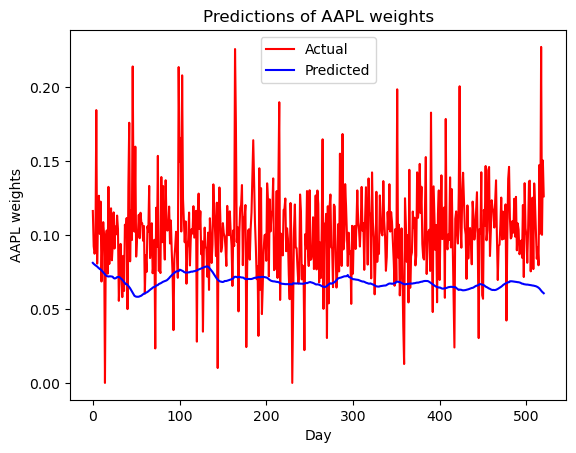

In [17]:
stock = 'AAPL'
col = stockList.index(stock)

plt.plot(y_test[:, col], color='red', label='Actual')
plt.plot(y_pred[:, col], color='blue', label='Predicted')
plt.title(f'Predictions of {stock} weights')
plt.xlabel('Day')
plt.ylabel(f'{stock} weights')
# plt.ylim([0, 0.2])
plt.legend()
plt.show()

In [18]:
print(f'y_pred: {y_pred[0][10:20]}')
print(f'y_test: {y_test[0][10:20]}')

y_pred: [0.08604573 0.0827397  0.09622557 0.08521362 0.08700309 0.08368921
 0.08162402 0.08806647 0.08711942 0.08593035]
y_test: [0.08672371 0.1488222  0.0720304  0.08318108 0.06489817 0.10231184
 0.10702614 0.13732215 0.05896204 0.07653483]


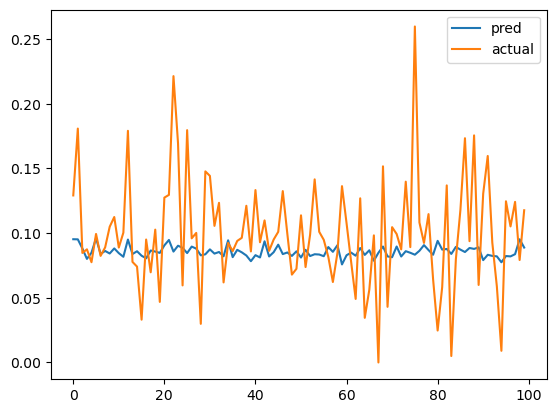

In [19]:
plt.plot(y_pred[2], label='pred')
plt.plot(y_test[2], label='actual')
plt.legend()
plt.show()

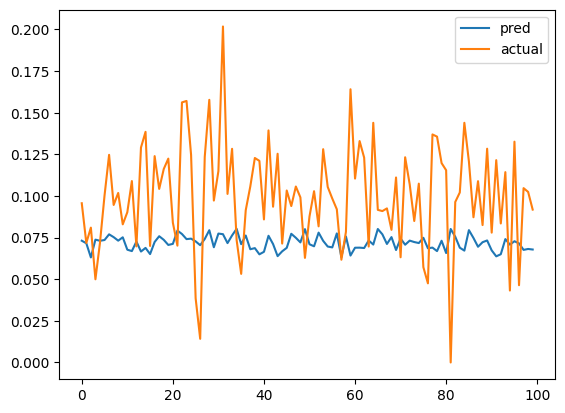

In [876]:
plt.plot(y_pred[40], label='pred')
plt.plot(y_test[40], label='actual')
plt.legend()
plt.show()

Generate table of predicted stock weights

In [20]:
weights_pred = pd.DataFrame(y_pred)
weights_pred.columns = stockList
weights_pred.index = testPrices.index.copy()
print(weights_pred.iloc[:, :5].head())
print(weights_pred.iloc[:, :5].tail())

                   A       AAL       AAP      AAPL       ABC
Date                                                        
2017-12-05  0.096606  0.096792  0.089416  0.081275  0.086257
2017-12-06  0.095882  0.095934  0.088678  0.080611  0.085494
2017-12-07  0.095297  0.095201  0.088146  0.080089  0.084867
2017-12-08  0.094769  0.094542  0.087686  0.079630  0.084317
2017-12-11  0.094321  0.093996  0.087324  0.079254  0.083863
                   A       AAL       AAP      AAPL       ABC
Date                                                        
2019-12-24  0.072532  0.073410  0.065446  0.063214  0.068033
2019-12-26  0.071694  0.072455  0.064531  0.062386  0.067243
2019-12-27  0.071061  0.071742  0.063846  0.061769  0.066667
2019-12-30  0.070492  0.071130  0.063222  0.061210  0.066165
2019-12-31  0.069985  0.070598  0.062651  0.060703  0.065726


portfolio evaluation

Index(['A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABMD', 'ABT', 'ACN', 'ADBE', 'ADI',
       'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AFL', 'AIG', 'AIZ', 'AJG',
       'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'AMAT', 'AMD', 'AME', 'AMGN',
       'AMP', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ARE',
       'ATO', 'ATVI', 'AVB', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX',
       'BBWI', 'BBY', 'BDX', 'BEN', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLK',
       'BMY', 'BR', 'BRO', 'BSX', 'BWA', 'BXP', 'C', 'CAG', 'CAH', 'CAT', 'CB',
       'CBRE', 'CCI', 'CCL', 'CDNS', 'CE', 'CF', 'CHD', 'CHRW', 'CI', 'CINF',
       'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP',
       'COF', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CRL', 'CRM', 'CSCO',
       'CSX'],
      dtype='object')
Annualized Return: 74.05%
Annualized Volatility: 102.16%
Sharpe Ratio: 0.70
Maximum Drawdown: -82.74%


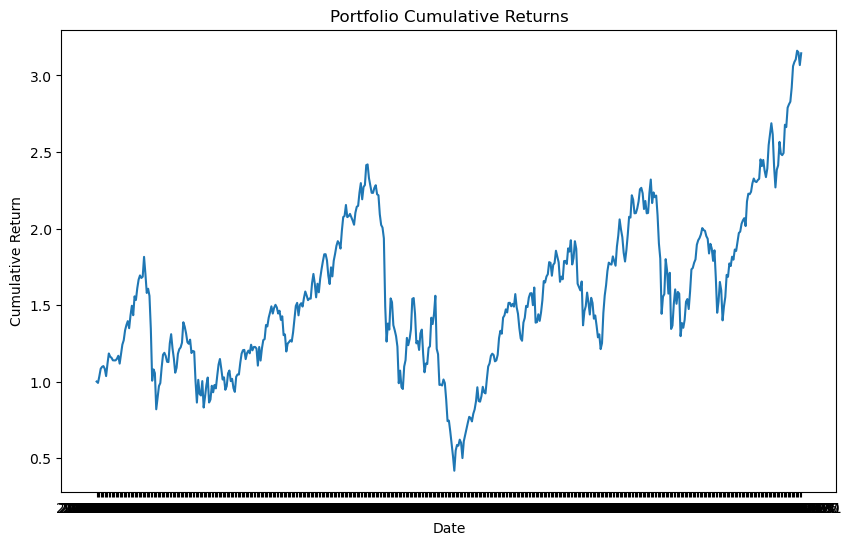

In [21]:
def backtest(test_df, weights):
    '''
    df of stocks with index being date, cols being stocks, each entry being the price 
    weights represent the normalized portfolio weights
    '''
    returns = test_df.pct_change().dropna()

    portfolio_returns = (returns * weights).sum(axis=1)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    # print(cumulative_returns)
    annualized_return = (cumulative_returns[-1])**(252/len(cumulative_returns.index)) - 1  # Assuming 252 trading days
    annualized_volatility = portfolio_returns.std() * np.sqrt(252)

    # Calculate Sharpe Ratio
    risk_free_rate = 0.03 # can change 
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    # Calculate Maximum Drawdown
    cumulative_returns_index = (1 + portfolio_returns).cumprod()
    cumulative_max = cumulative_returns_index.cummax()
    drawdown = (cumulative_returns_index - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    print(f"Annualized Return: {annualized_return:.2%}")
    print(f"Annualized Volatility: {annualized_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")

    plt.figure(figsize=(10,6))
    plt.plot(cumulative_returns)
    plt.title('Portfolio Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.show()

print(testPrices.columns)
backtest(testPrices, weights_pred)
# backtest(test_prices, weights_pred_test)